# <center>SFML/INFO-F422: Statistical foundations of machine learning</center>

# <center>Classification notebook</center>

# <center>Impact of mislabelled data on classification performance:</center>

Name: Mathieu Parmentier & Nilson Toula

Matricule: 000502042 & 000506378

Python version: 3.7

Date: 07/06/2020


# Introduction

As part of the Statistical foundations of machine learning course, we had to conduct a machine learning research project on an issue of our choice. We chose to study the impact of mislabelled data on classification. This question was motivated by the fact that recording a measure with a mislabelled name is not an uncommon occurrence. Moreover, this problem shares the same consequences as the problem of data sets with outliers.

This work has been done with python version 3.7. We chose to study the following algorithms: Gaussian Naive Bayes, Support vector classifier, Nearest Neighbors Classification, and Random Forest Classifier. All the algorithms come from the "scikit-learn" library.

This work begins with a theoretical reminder of each of the algorithms with a setting from the perspective of their classification compared to simple data without noise in the absence and presence of mislabelled points. Each algorithm will be treated individually. Then, we will analyze the classification according to the percentage of mislabelled points for data with a slight noise. The last part of the work before the conclusion is devoted to the analysis of real data where we inverted the labels of some data-point to test the robustness of the algorithms. 

### Quality of the model

<center>Confusion matrix:</center>

|||Predicted|class|
|---|---|---|---|
|||0|1|
|True|0|TP|FN|
|class|1|FP|TN|

We will evaluate our models in function of its precision, recall, F1-score, and accuracy. These different indicators of model quality are calculated using the confusion matrix above. The equations of those indicators are shown below. It is important to note that the in-sample error, out-sample error, and cross-validation score are calculated using the R² formula.

Equations:

$$Precision = \frac{True Positive (TP)}{True Positive (TP) + False Positive (FP)} $$

$$Recall = \frac{True Positive (TP)}{True Positive (TP) + False Negative (FN)} $$

$$F1-score = \frac{Precision * Reall}{Precision + Reall} $$

$$Accuracy = \frac{True Positive (TP) + True Negative (TN)}{Total} $$


## Influence of the outliers on the models for simple dataset without  noise

The purpose of this part is to show the classification capability of each of the algorithms for a simple synthetic data set with or without mislabels.  

### Synthetic data set:

We have chosen to generate a two-class dataset, noiseless, non-linear, as simple as possible, visual, and unambiguous.  To do this, we generate two concentric circles where each of the points of the same circle belongs to the same class. Then, we construct a second data set which is a copy of the first data set except for annotation errors (class inversion of some points) which are added thanks to the "flip" function. 

In [2]:
import pylab as pl, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles

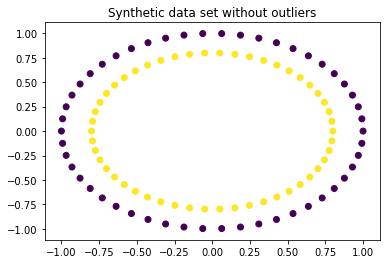

In [3]:
np.random.seed(42)
X,Y = make_circles(n_samples=100, noise=0, factor=0.8)
pl.scatter(X[:, 0], X[:, 1], marker='o', c=Y)
plt.title("Synthetic data set without outliers")
plt.show()

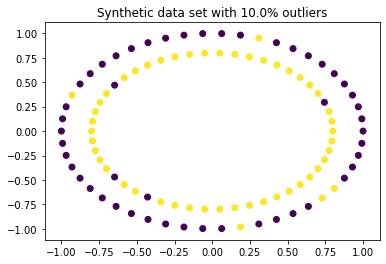

In [4]:
def flip(rate,y):
    number = int(round(len(y)*rate))
    flag = True
    i = 0
    cl_a = 0
    cl_b = 0
    while flag:
        if y[i] == 0 and cl_a != number//2:
            cl_a += 1
            y[i] = 1
        elif y[i] == 1 and cl_b != number//2:
            cl_b += 1
            y[i] = 0
        else:
            flag = False
        i += 1
    outliers = cl_a + cl_b
    return y, outliers


Yo = np.copy(Y)
outlier_rate = 0.1
Yo, outliers = flip(outlier_rate,Yo)
pl.scatter(X[:, 0], X[:, 1], marker='o', c=Yo)
plt.title("Synthetic data set with {}% outliers".format(outlier_rate*100))
plt.show()

Each of the two versions of the data set is separated into a training-test set. Each algorithm is then trained and tested, once with the data without outliers and a second time with the data with outliers. We would like to draw your attention to the fact that each test set is only used for its own training set.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = .2, random_state = 25)
xo_train, xo_test, yo_train, yo_test = train_test_split(X, Yo, test_size = .2, random_state = 25)

### 1) Algorithm: Gaussian Naive Bayes

#### a) Introduction
Gaussian Naive Bayes(GNB) algorithm is a probabilistic-based algorithm.

  ##### - Theoretical approach
Let $ \{(x_n, y_n) : x_n \in \mathbb{R}^d, y_n \in \{-1;1\} \} $ be the training set, $n= 1,\dots, N$ . 
The hypothesis space  of the Gaussian Naive Bayes or GNB is: 
   $$\mathcal{H}_{GNB} = \{ h \in \mathcal{H} : h(x) = P(y_n \mid x_n) \}$$
   
   Where $P(y_n \mid x_n)$ is the posterior probability of the well known Bayes Formula:
    
$$P(y \mid x) = \frac{P(y) P(x \mid y)}{P(x)}$$



In this algorithm we assume that the values associated with each class are distributed according to a Gaussian (also called Normal) law:
       $$P(x_i \mid y) = \frac{1}{\sqrt{2\pi\sigma^2_y}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma^2_y}\right)$$
   Where $\mu$ is the mean of the distribution, $\sigma$ is the standard deviation (nb: $\sigma^2$ is the variance of the distribution).       


   * Learning phase  
To compute $P(y_n \mid x_n)$, we need to get the evidence of every data-point $P(x_n)$, then for every class $y_n$ we compute the likelihood of the features in those classes $P(x_{n_i} \mid y_n)$, and the prior probability $P(y_n)$, then we stock those values in a data structure or compute them on the fly since those operations are really simple to compute.  



   * Classification phase  
For every point we want to test $x_{test}$ , we compute $h(x_{test}) = \operatorname*{arg\,max}_{y_n}( P(y_n \mid x_{test}) )$  

##### - Discussion


   * Why do we call it naive?  
   This algorithm is said Naive because we assume that our model correctly simulate the real world and that all the attribute is independent (we don't model any of the interrelationship between the attributes).
  But in this case, we are not focusing on what is exactly the probability (we said that GNB is a bad estimator) but the order of that probability, aiming to compare them to one another. So the correctness of $P(y_n \mid x_n)$ does not really matter as long as for every other y': $P(y_n \mid x_n) >> P(y' \mid x_n)$ .  
  
  
     
   * Practical flaw  
  Another issue is when we encounter a new attribute combination we have never seen before, we will have $P(x_n \mid y_n) = 0$
  Which will compromise our calculations, to counteract that, we will smooth the our probabilities by initializing any probability to a value different than 0. Doing so is admitting that there is an inductive bias in our data which makes our algorithm "less naive".  


<font color="gray"> Sources:</font>
<br><br>
<font color="gray"> Abu-Mostafa, Yaser S., 1957-. (2012). Learning from data : a short course. [United States] :AMLBook.com, </font>
<br><br><font color="gray">Udacity SL6 - Kernel mathods & SVMs: https://www.udacity.com/</font>
<br><br> <font color="gray">Scikit-Learn: https://scikit-learn.org/stable/modules/naive_bayes.html</font>
<br><br> <font color="gray">Zhang, H. (2004). The optimality of naive Bayes. AA, 1(2), 3.</font>
<br><br> <font color="gray">Augmented Startups youtube video: https://youtu.be/CPqOCI0ahss</font>


#### b) Application on a synthetic data set without outliers

##### b.1) Code

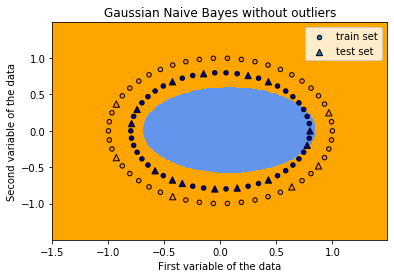

In [6]:
from sklearn.naive_bayes import GaussianNB

# model building
GNB = GaussianNB()
GNB.fit(x_train, y_train)


#Plot part
cmap_area = ListedColormap(['orange', 'cornflowerblue'])
cmap_point = ListedColormap(['darkorange', 'darkblue'])

x_min, x_max = X[:, 0].min() -0.5, X[:, 0].max() +0.5
y_min, y_max = X[:, 1].min() -0.5, X[:, 1].max() +0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),np.arange(y_min, y_max, 0.01))
Z = GNB.predict(np.c_[xx.ravel(), yy.ravel()])

## Put area prediction into a color classe
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_area)

## Plot all the data points
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cmap_point,edgecolor='black', s=20, label="train set")
plt.scatter(x_test[:,0], x_test[:,1], c=y_test, edgecolor="black", cmap=cmap_point,marker = '^', s=40, label="test set")

plt.xlabel("First variable of the data")
plt.ylabel("Second variable of the data")
plt.title("Gaussian Naive Bayes without outliers")
plt.legend()
plt.show()

<font color="gray"> Sources:</font>
<br><br> <font color="gray">Scikit-Learn: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html</font>

##### b.2) Score

In [7]:
#Computation of E in and E out
E_in_GNB = GNB.score(x_train, y_train)
E_out_GNB = GNB.score(x_test, y_test)

#cross validation of the model with cv = 5
cv_scores_GNB = cross_val_score(GNB, X, Y, cv=5)

#print score
print("In-sample error :",E_in_GNB)
print("Out-sample error :",E_out_GNB)
print("cross validation mean score for GNB :",round(np.mean(cv_scores_GNB),4))
print()
print('Classification report:')
print(classification_report(y_test,GNB.predict(x_test)))

In-sample error : 0.6
Out-sample error : 0.4
cross validation mean score for GNB : 0.7

Classification report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         6
           1       1.00      0.14      0.25        14

    accuracy                           0.40        20
   macro avg       0.67      0.57      0.38        20
weighted avg       0.80      0.40      0.33        20



The absence of hyperparameters does not allow us to optimize the model, which forces us to use the default parameters.  Therefore the Gaussian Naive Bayes does not allow to separate satisfactorily the two classes of points, consistent with the classification report (accuracy = 0.4) and the graph.

#### c) Application on a synthetic data set with outliers

##### c.1) Code

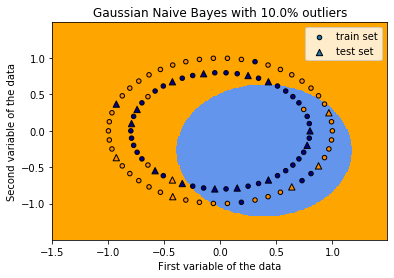

In [8]:
# model building
GNBo = GaussianNB()
GNBo.fit(xo_train, yo_train)


#Plot part
cmap_area = ListedColormap(['orange', 'cornflowerblue'])
cmap_point = ListedColormap(['darkorange', 'darkblue'])

x_min, x_max = X[:, 0].min() -0.5, X[:, 0].max() +0.5
y_min, y_max = X[:, 1].min() -0.5, X[:, 1].max() +0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),np.arange(y_min, y_max, 0.01))
Z = GNBo.predict(np.c_[xx.ravel(), yy.ravel()])

## Put area prediction into a color classe
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_area)

## Plot all the data points
plt.scatter(xo_train[:, 0], xo_train[:, 1], c=yo_train, cmap=cmap_point,edgecolor='black', s=20, label="train set")
plt.scatter(xo_test[:,0], xo_test[:,1], c=yo_test, edgecolor="black", cmap=cmap_point,marker = '^', s=40, label="test set")

plt.xlabel("First variable of the data")
plt.ylabel("Second variable of the data")
plt.title("Gaussian Naive Bayes with {}% outliers".format(outlier_rate*100))
plt.legend()
plt.show()

##### c.2) Score

In [9]:
#Computation of E in and E out
E_in_GNBo = GNBo.score(xo_train, yo_train)
E_out_GNBo = GNBo.score(xo_test, yo_test)

#cross validation of the model with cv = 5
cv_scores_GNBo = cross_val_score(GNBo, X, Yo, cv=5)

#print scores
print("In-sample error :",E_in_GNBo)
print("Out-sample error :",E_out_GNBo)
print("cross validation mean score for GNB :",round(np.mean(cv_scores_GNBo),4))
print()
print('Classification report for {}% outliers :'.format(outlier_rate*100))
print(classification_report(yo_test,GNBo.predict(xo_test)))

In-sample error : 0.6375
Out-sample error : 0.4
cross validation mean score for GNB : 0.6427

Classification report for 10.0% outliers :
              precision    recall  f1-score   support

           0       0.25      0.50      0.33         6
           1       0.62      0.36      0.45        14

    accuracy                           0.40        20
   macro avg       0.44      0.43      0.39        20
weighted avg       0.51      0.40      0.42        20



The model does not seem to be affected by outliers according to the classification report (accuracy always equal to 0.4). Nevertheless, we can see on the graph that the area of the central class widens and moves in the direction where the concentration of outliers is highest.

### 2) Algorithm: Support vector classifier

#### a) Introduction
Support Vector Machine is an algorithm aiming to create a function maximizing the soft margin between each class for that function to correctly design a classification threshold between classes.
In other words, a support vector machine (SVM) is a combination between a support vector classifier and a non-linear kernel.

   * Theoretical approach  
Let $ \{(x_n, y_n) : x_n \in \mathbb{R}^d, y_n \in \{-1;1\} \} $ be the training set, $n= 1,\dots, N$ . 
The hypothesis space  of the SVM is: 
   $$\mathcal{H}_{SVM} = \{ h \in \mathcal{H} : h(x) = sign(\langle w, \varphi(x)\rangle_{ \mathcal{H}}  +b) \mid w \in \mathcal{H}, b \in \mathbb{R} \}$$
   
  Where $\varphi(x)$ is the feature function from the input space $\mathcal{X}$ to the feature space $\mathcal{H}$ where we compute the maximum margin separtion. $\varphi(x)$ correspond to the kernel by: $k(x,y) = \langle \varphi(x),\varphi(y) \rangle_\mathcal{H}$
  
  To do so, we are computing high-dimensional relations between the points without actually transforming them to the higher dimensions, we call this method The Kernel Trick, which reduces the amount of computation required for SVM and allow calculating relationship in an infinite dimension space $\mathcal{H}$.
  That computation will be of the form: $ w = \sum_{n=1}^{d} \alpha_n . \varphi(x_n)$, implying:
  
$$ \langle w, \varphi (x_n) \rangle_{\mathcal{H}} = \big\langle \sum_{n=1}^{d} \alpha_n \varphi(x_n), \varphi(x_n) \big\rangle_\mathcal{H} = \sum_{n=1}^d \alpha_n \langle \varphi(x_n) , \varphi(x_n) \rangle_\mathcal{H} = \sum_{n=1}^d \alpha_n k(x_n, x_n) $$

Thus, we can only consider $\mathcal{H}_{SVM}^X \subset \mathcal{H}_{SVM}$ as our hypothesis space:
$$ \mathcal{H}_{SVM}^X = \big\{h \in \mathcal{H}: h(x) = sign\big( \sum_{n=1}^d ( \alpha_n k(x_n, x_n)) +b \big) \mid \alpha \in \mathbb{R}^d, b\in \mathbb{R} \big\}$$

We will call support vector with $\alpha_i \neq 0 $ .


   * Learning phase  
To find the best support vector, we use cross-validation to iterate this two step algorithm:  
            * First, we compute the relation between data-point into a higher dimension using the kernel trick.
            * Then, we find a support vector classifier that separates the higher dimensional data into two groups an use it as a threshold.


   *  Classification phase  
We classify any new points according to feature-threshold we compute previously during the learning phase.


<font color="gray"> Sources:</font>
<br><br><font color="gray"> Abu-Mostafa, Yaser S., 1957-. (2012). Learning from data : a short course. [United States] :AMLBook.com, </font>
<br><br><font color="gray"> Space reductionn demonstration by Dougal: https://stats.stackexchange.com/users/9964/dougal  </font>
<br><br><font color="gray">StatQuest with Josh Starmer: https://youtu.be/efR1C6CvhmE  , based on Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani. (2013). An introduction to statistical learning : with applications in R. New York :Springer, chap 9.1 to 9.4 </font>



#### b) Application on a synthetic data set without outliers

##### b.1) Code

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

The optimize settings are {'C': 10, 'kernel': 'rbf'}


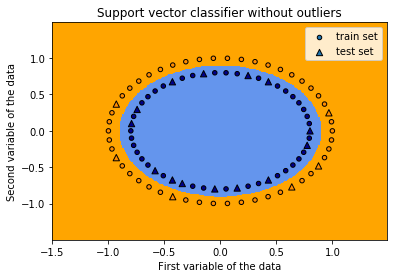

In [10]:
from sklearn.svm import SVC


# model building
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
## Where C is Regularization parameter
svc_opt = GridSearchCV(SVC(), param_grid, cv=5, verbose=0)
svc_opt.fit(x_train, y_train)
print('The optimize settings are',svc_opt.best_params_)
svc_opt = SVC(C = svc_opt.best_params_['C'],kernel = svc_opt.best_params_['kernel'])
svc_opt.fit(x_train, y_train)

#Plot part
cmap_area = ListedColormap(['orange', 'cornflowerblue'])
cmap_point = ListedColormap(['darkorange', 'darkblue'])

x_min, x_max = X[:, 0].min() -0.5, X[:, 0].max() +0.5
y_min, y_max = X[:, 1].min() -0.5, X[:, 1].max() +0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),np.arange(y_min, y_max, 0.01))
Z = svc_opt.predict(np.c_[xx.ravel(), yy.ravel()])

## Put area prediction into a color classe
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_area)

## Plot all the data points
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolor="black", cmap=cmap_point, s=20, label="train set")
plt.scatter(x_test[:,0], x_test[:,1], c=y_test, edgecolor="black",marker = '^', cmap=cmap_point, s=40, label="test set")

plt.xlabel("First variable of the data")
plt.ylabel("Second variable of the data")
plt.title("Support vector classifier without outliers")
plt.legend()
plt.show()

<font color="gray"> Sources:</font>
<br><br> <font color="gray">Scikit-Learn: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html</font>

##### b.2) Score

In [11]:
#Computation of E in and E out
E_in_svc_opt = svc_opt.score(x_train, y_train)
E_out_svc_opt = svc_opt.score(x_test, y_test)

#cross validation of the model with cv = 5
cv_scores_svc = cross_val_score(svc_opt, X, Y, cv=5)

#print scores
print("In-sample error :",E_in_svc_opt)
print("Out-sample error :",E_out_svc_opt)
print("cross validation mean score for SVC :",round(np.mean(cv_scores_svc),4))
print()
print('Classification report:')
print(classification_report(y_test,svc_opt.predict(x_test)))

In-sample error : 1.0
Out-sample error : 1.0
cross validation mean score for SVC : 1.0

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        14

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

The Support vector classifier after optimization allows to satisfactorily separate the two classes of points consistent with the classification report (accuracy = 1) and the graph.

#### c) Application on a synthetic data set with outliers

##### c.1) Code

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

The optimize settings are {'C': 10, 'kernel': 'rbf'}


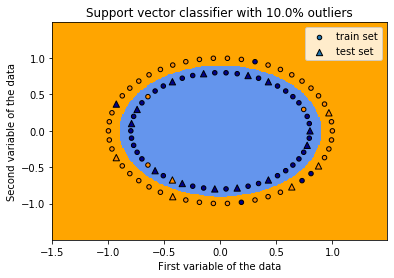

In [12]:
# model building
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
## Where C is Regularization parameter
svc_opto = GridSearchCV(SVC(), param_grid, cv=5, verbose=0)
svc_opto.fit(xo_train, yo_train)
print('The optimize settings are',svc_opto.best_params_)
svc_opto = SVC(C = svc_opto.best_params_['C'],kernel = svc_opto.best_params_['kernel'])
svc_opto.fit(xo_train, yo_train)

#Plot part
cmap_area = ListedColormap(['orange', 'cornflowerblue'])
cmap_point = ListedColormap(['darkorange', 'darkblue'])

x_min, x_max = X[:, 0].min() -0.5, X[:, 0].max() +0.5
y_min, y_max = X[:, 1].min() -0.5, X[:, 1].max() +0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),np.arange(y_min, y_max, 0.01))
Z = svc_opto.predict(np.c_[xx.ravel(), yy.ravel()])

## Put area prediction into a color classe
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_area)

## Plot all the data points
plt.scatter(xo_train[:, 0], xo_train[:, 1], c=yo_train, edgecolor="black", cmap=cmap_point, s=20, label="train set")
plt.scatter(xo_test[:,0], xo_test[:,1], c=yo_test, edgecolor="black",marker = '^', cmap=cmap_point, s=40, label="test set")

plt.xlabel("First variable of the data")
plt.ylabel("Second variable of the data")
plt.title("Support vector classifier with {}% outliers".format(outlier_rate*100))
plt.legend()
plt.show()

##### c.2) Score

In [13]:
#Computation of E in and E out
E_in_svc_opto = svc_opto.score(xo_train, yo_train)
E_out_svc_opto = svc_opto.score(xo_test, yo_test)

#cross validation of the model with cv = 5
cv_scores_svco = cross_val_score(svc_opto, X, Yo, cv=5)

#print scores
print("In-sample error :",E_in_svc_opto)
print("Out-sample error :",E_out_svc_opto)
print("cross validation mean score for svc :",round(np.mean(cv_scores_svco),4))
print()
print('Classification report for {}% outliers :'.format(outlier_rate*100))
print(classification_report(yo_test,svc_opto.predict(xo_test)))

In-sample error : 0.9125
Out-sample error : 0.9
cross validation mean score for svc : 0.9143

Classification report for 10.0% outliers :
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.93      0.93      0.93        14

    accuracy                           0.90        20
   macro avg       0.88      0.88      0.88        20
weighted avg       0.90      0.90      0.90        20



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

The model graph appears to be identical to the previous one (b.1). We can also see that there is a decrease in accuracy from 1 to 0.9 which we expected. This result seems to indicate that this algorithm isn't sensitive to outliers, this property is probably linked to the "soft margin" nature of SMV.

### 3) Algorithm: Nearest Neighbors Classification


#### a) Introduction 

k-Nearest Neighbors is a lazy algorithm that can be used for either classification or regression. Here we will talk about the classification version.

The K nearest neighbor algorithm never builds an explicit hypothesis, how the algorithm will behave depends on the similarities (or distance) function chosen for the evaluation of any feature and the number of evaluated points $k$.
Although, given a training set we can determine the implicit function that is computed.
  

  ##### **Theoretical approach with k=1**   
   
Let $ S = \{(x_n, y_n) : x_n \in \mathbb{R}^d, y_n \in \{-1;1\} \} $ be the training set, $n= 1,\dots, N$ .  

 * For any $x_n$ in the training set, let $d(x_i)_{x_n}$ be a similarity function (or distance) between $x_n$ and $x_i$
 
 Then a Voronoi cell will be an area $A_n$ containing only one element of the training set such that: $\forall x_i \in (x_i, y_i): a \in A_n \iff d(a)_{x_n} = min(d(a)_{x_i}) $

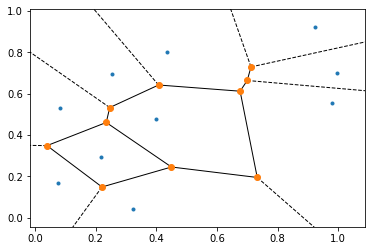

In [14]:
# Exemple of Voronoi cells
points = np.random.rand(10,2)

from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)
fig = voronoi_plot_2d(vor)

plt.show()

* Learning phase
   
We compute every Voronoi cell $A_n$, then save the corresponding Voronoi tesselation $A_{y_n}$(i.e. we save the bondaries of $A_{y_n} := \big\{\bigcup_{x \in S} A_{x_i} \mid \forall i \in \{-1;1\}: y_i = y_n  \big\} $).

   * Classification phase  

We assign to any new data-point $x_{new}$ a value corresponding to the $A_{y_n}$ it's included in.

   ##### Generalization for any k
 
  For the smallest $l \geq k$ possible, we assign $y_{new}$ according to a voting method $ y_i$ for all $l$-closest neighbors of $x_{new}$ (e.i. $ \forall i \in I: \nexists k, d(x_{new})_{x_i} \leq d(x_{new})_{x_k} $, and $ \mid I \mid = l$ ).
 
   ##### Alternative
  * Most of the time we use plurality voting as a voting method, but we can also use weighted votes where for example weights of the votes can be liked to the distance or can be affected regarding the cardinal of there class.
   
  * The similarity function also plays a huge role in the output (especially in regression), and figuring out the best overall similarity function for any data-set can be computation-intensive, but finding the adequate similarity function can allow a unparallel exploitation the data
   
  *  Also the choice of $k$ can't be too large compared to the number of points $n$, we can use cross-validation to find an adequate $k$ value. 

<font color="gray"> Sources:</font>
<br><br><font color="gray"> University of Utah - Machine learning course  </font>
<br><br><font color="gray"> StatQuest with josh Stamer: https://youtu.be/HVXime0nQeI  </font>
<br><br><font color="gray"> Udacty, SL4 - Intance based learning https://www.udacity.com/ </font>

#### b) Application on a synthetic data set without outliers

##### b.1) Code

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The optimize settings are {'leaf_size': 2, 'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}


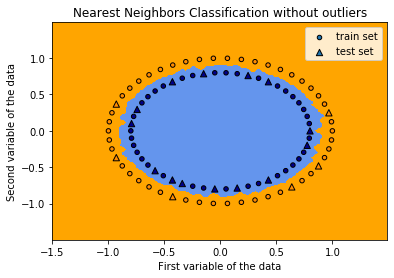

In [15]:
from sklearn import neighbors


# model building
param_grid = {"n_neighbors": [2,3,4,5,6,7,8,9],"leaf_size": [2,5,10,20,30,50,100], "weights": ["uniform", "distance"], "metric": ["euclidean", "manhattan"]}
knn_opt = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, cv=5, verbose=0)
knn_opt.fit(x_train, y_train)
print('The optimize settings are',knn_opt.best_params_)
knn_opt = neighbors.KNeighborsClassifier(n_neighbors = knn_opt.best_params_['n_neighbors'],leaf_size = knn_opt.best_params_['leaf_size'],weights = knn_opt.best_params_['weights'],metric = knn_opt.best_params_['metric'])
knn_opt.fit(x_train, y_train)

#Plot part
cmap_area = ListedColormap(['orange', 'cornflowerblue'])
cmap_point = ListedColormap(['darkorange', 'darkblue'])

x_min, x_max = X[:, 0].min() -0.5, X[:, 0].max() +0.5
y_min, y_max = X[:, 1].min() -0.5, X[:, 1].max() +0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),np.arange(y_min, y_max, 0.01))
Z = knn_opt.predict(np.c_[xx.ravel(), yy.ravel()])

## Put area prediction into a color classe
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_area)

## Plot all the data points
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolor="black", cmap=cmap_point, s=20, label="train set")
plt.scatter(x_test[:,0], x_test[:,1], c=y_test, edgecolor="black",marker = '^', cmap=cmap_point, s=40, label="test set")

plt.xlabel("First variable of the data")
plt.ylabel("Second variable of the data")
plt.title("Nearest Neighbors Classification without outliers")
plt.legend()
plt.show()

<font color="gray"> Sources:</font>
<br><br> <font color="gray">Scikit-Learn: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html</font>

##### b.2) Score

In [16]:
#Computation of E in and E out
E_in_knn_opt = knn_opt.score(x_train, y_train)
E_out_knn_opt = knn_opt.score(x_test, y_test)

#cross validation of the model with cv = 5
cv_scores_knn_opt = cross_val_score(knn_opt, X, Y, cv=5)

#print scores
print("In-sample error :",E_in_knn_opt)
print("Out-sample error :",E_out_knn_opt)
print("cross validation mean score for k-NN :",round(np.mean(cv_scores_knn_opt),4))
print()
print('Classification report:')
knn_opt_ypred = knn_opt.predict(x_test)
knn_opt_ypred = knn_opt_ypred > 0.5
print(classification_report(y_test,knn_opt_ypred))

In-sample error : 1.0
Out-sample error : 1.0
cross validation mean score for k-NN : 0.99

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        14

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



The Nearest Neighbors Classification after optimization allows to satisfactorily separate the two classes of points consistent with the classification report (accuracy = 1) and with the graph.

#### c) Application on a synthetic data set with outliers

##### c.1) Code

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The optimize settings are {'leaf_size': 2, 'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}


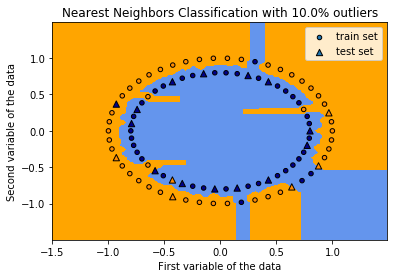

In [17]:
# model building
param_grid = {"n_neighbors": [2,3,4,5,6,7,8,9],"leaf_size": [2,5,10,20,30,50,100], "weights": ["uniform", "distance"], "metric": ["euclidean", "manhattan"]}
knn_opto = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, cv=5, verbose=0)
knn_opto.fit(xo_train, yo_train)
print('The optimize settings are',knn_opto.best_params_)
knn_opto = neighbors.KNeighborsClassifier(n_neighbors = knn_opto.best_params_['n_neighbors'],leaf_size = knn_opto.best_params_['leaf_size'],weights = knn_opto.best_params_['weights'],metric = knn_opto.best_params_['metric'])
knn_opto.fit(xo_train, yo_train)

#Plot part
cmap_area = ListedColormap(['orange', 'cornflowerblue'])
cmap_point = ListedColormap(['darkorange', 'darkblue'])

x_min, x_max = X[:, 0].min() -0.5, X[:, 0].max() +0.5
y_min, y_max = X[:, 1].min() -0.5, X[:, 1].max() +0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),np.arange(y_min, y_max, 0.01))
Z = knn_opto.predict(np.c_[xx.ravel(), yy.ravel()])

## Put area prediction into a color classe
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_area)

## Plot all the data points
plt.scatter(xo_train[:, 0], xo_train[:, 1], c=yo_train, edgecolor="black", cmap=cmap_point, s=20, label="train set")
plt.scatter(xo_test[:,0], xo_test[:,1], c=yo_test, edgecolor="black",marker = '^', cmap=cmap_point, s=40, label="test set")

plt.xlabel("First variable of the data")
plt.ylabel("Second variable of the data")
plt.title("Nearest Neighbors Classification with {}% outliers".format(outlier_rate*100))
plt.legend()
plt.show()

##### c.2) Score

In [18]:
#Computation of E in and E out
E_in_knn_opto = knn_opto.score(xo_train, yo_train)
E_out_knn_opto = knn_opto.score(xo_test, yo_test)

#cross validation of the model with cv = 5
cv_scores_knn_opto = cross_val_score(knn_opto, X, Yo, cv=5)

#print scores
print("In-sample error :",E_in_knn_opto)
print("Out-sample error :",E_out_knn_opto)
print("cross validation mean score for svc :",round(np.mean(cv_scores_knn_opto),4))
print()
print('Classification report for {}% outliers :'.format(outlier_rate*100))
knn_opto_ypred = knn_opto.predict(xo_test)
knn_opto_ypred = knn_opto_ypred > 0.5
print(classification_report(yo_test,knn_opto_ypred))

In-sample error : 1.0
Out-sample error : 0.85
cross validation mean score for svc : 0.8227

Classification report for 10.0% outliers :
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.92      0.86      0.89        14

    accuracy                           0.85        20
   macro avg       0.82      0.85      0.83        20
weighted avg       0.86      0.85      0.85        20



Due to its nature of lazy learner algorithm, the Nearest Neighbors Classification trained on a data set containing outliers attend to prevent misclassification of outliers, which results in a much more complex Voronoi cell. This hypothesis is reinforced by the classification report which has a fairly good accuracy = 0.85 for an outlier rate of 10%. This result seems to indicate that this algorithm is more sensitive to outliers. 

### 4) Algorithm: Random Forest Classifier


#### a) Introduction 


A random forest is a set of decision trees all trained on a bootstrapping of the training set and aggregating their results (i.e. it's a bagging method).

  

     Theoretical approach 

Let $ S = \{(x_n, y_n) : x_n \in \mathbb{R}^d, y_n \in \{-1;1\} \} $ be the training set, $n= 1,\dots, N$.



      Learning phase 
      
From $S$, we extract $M>0 \in \mathbb{N} $ bootstraped set $S_m$ each composed of $a_m \in \{1,..., n\}$ data points from $S$.
For every $S_m$ we grow a tree $T_m : x \in \mathbb{R}^d \rightarrow \{-1;1\}$ by only considering a random number of variables at each step.

Then we iterate those steps several times changing the number of variables considered and use out of bag values to determine the most accurate architecture.

        Classification phase 

For any new point $x_{new}$ we determine $y_{new}$ by a voting method (most of the time we use $y_{new} = \operatorname*{arg\,max}_{y_n}( T(x_{new}))$ for classification problems)
  

<font color="gray"> Sources:</font>
<br><br><font color="gray"> Biau, G., & Scornet, E. (2016). A random forest guided tour. TEST, 25(2), 197–227. https://doi.org/10.1007/s11749-016-0481-7  </font>
<br><br><font color="gray"> StatQuest with josh Stamer: https://youtu.be/J4Wdy0Wc_xQ </font>


#### b) Application on a synthetic data set without outliers

##### b.1) Code

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

The optimize settings are {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


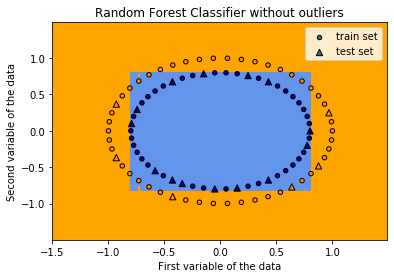

In [19]:
from sklearn.ensemble import RandomForestClassifier


# model building
param_grid = {'criterion': ['entropy', 'gini'],'max_depth': [2, 3, 5, 10],'min_samples_split': [2, 3, 5],'min_samples_leaf': [1, 5, 8]}
RFC_opt = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, verbose=0)
RFC_opt.fit(x_train, y_train)
print('The optimize settings are',RFC_opt.best_params_)
RFC_opt = RandomForestClassifier(criterion = RFC_opt.best_params_['criterion'],max_depth = RFC_opt.best_params_['max_depth'],min_samples_split = RFC_opt.best_params_['min_samples_split'],min_samples_leaf = RFC_opt.best_params_['min_samples_leaf'])
RFC_opt.fit(x_train, y_train)

#Plot part
cmap_area = ListedColormap(['orange', 'cornflowerblue'])
cmap_point = ListedColormap(['darkorange', 'darkblue'])

x_min, x_max = X[:, 0].min() -0.5, X[:, 0].max() +0.5
y_min, y_max = X[:, 1].min() -0.5, X[:, 1].max() +0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),np.arange(y_min, y_max, 0.01))
Z = RFC_opt.predict(np.c_[xx.ravel(), yy.ravel()])

## Put area prediction into a color classe
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_area)

## Plot all the data points
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolor="black", cmap=cmap_point, s=20, label="train set")
plt.scatter(x_test[:,0], x_test[:,1], c=y_test, edgecolor="black",marker = '^', cmap=cmap_point, s=40, label="test set")

plt.xlabel("First variable of the data")
plt.ylabel("Second variable of the data")
plt.title("Random Forest Classifier without outliers")
plt.legend()
plt.show()

<font color="gray"> Sources:</font>
<br><br> <font color="gray">Scikit-Learn: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html</font>

##### b.2) Score

In [20]:
#Computation of E in and E out
E_in_RFC_opt = RFC_opt.score(x_train, y_train)
E_out_RFC_opt = RFC_opt.score(x_test, y_test)

#cross validation of the model with cv = 5
cv_scores_RFC_opt = cross_val_score(RFC_opt, X, Y, cv=5)

#print scores
print("In-sample error :",E_in_RFC_opt)
print("Out-sample error :",E_out_RFC_opt)
print("cross validation mean score for RFC :",round(np.mean(cv_scores_RFC_opt),4))
print()
print('Classification report:')
print(classification_report(y_test,RFC_opt.predict(x_test)))

In-sample error : 0.9125
Out-sample error : 0.95
cross validation mean score for RFC : 0.9

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.93      1.00      0.97        14

    accuracy                           0.95        20
   macro avg       0.97      0.92      0.94        20
weighted avg       0.95      0.95      0.95        20



The Random Forest Classifier after optimization makes it possible to separate in a satisfactory way the two classes of points in agreement with the report of classification (accuracy =0.95) however the graph seems special: it approximates a circle by a square (rough approximation).

#### c) Application on a synthetic data set with outliers

##### c.1) Code

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

The optimize settings are {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


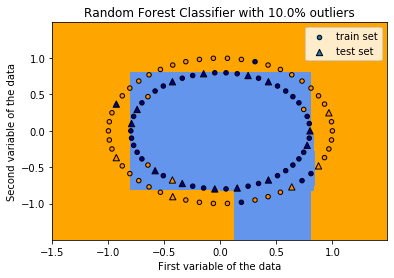

In [21]:
# model building
param_grid = {'criterion': ['entropy', 'gini'],'max_depth': [2, 3, 5, 10],'min_samples_split': [2, 3, 5],'min_samples_leaf': [1, 5, 8]}
RFC_opto = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, verbose=0)
RFC_opto.fit(xo_train, yo_train)
print('The optimize settings are',RFC_opto.best_params_)
RFC_opto = RandomForestClassifier(criterion = RFC_opto.best_params_['criterion'],max_depth = RFC_opto.best_params_['max_depth'],min_samples_split = RFC_opto.best_params_['min_samples_split'],min_samples_leaf = RFC_opto.best_params_['min_samples_leaf'])
RFC_opto.fit(xo_train, yo_train)

#Plot part
cmap_area = ListedColormap(['orange', 'cornflowerblue'])
cmap_point = ListedColormap(['darkorange', 'darkblue'])

x_min, x_max = X[:, 0].min() -0.5, X[:, 0].max() +0.5
y_min, y_max = X[:, 1].min() -0.5, X[:, 1].max() +0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),np.arange(y_min, y_max, 0.01))
Z = RFC_opto.predict(np.c_[xx.ravel(), yy.ravel()])

## Put area prediction into a color classe
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_area)

## Plot all the data points
plt.scatter(xo_train[:, 0], xo_train[:, 1], c=yo_train, edgecolor="black", cmap=cmap_point, s=20, label="train set")
plt.scatter(xo_test[:,0], xo_test[:,1], c=yo_test, edgecolor="black",marker = '^', cmap=cmap_point, s=40, label="test set")

plt.xlabel("First variable of the data")
plt.ylabel("Second variable of the data")
plt.title("Random Forest Classifier with {}% outliers".format(outlier_rate*100))
plt.legend()
plt.show()

##### c.2) Score

In [22]:
#Computation of E in and E out
E_in_RFC_opto = RFC_opto.score(xo_train, yo_train)
E_out_RFC_opto = RFC_opto.score(xo_test, yo_test)

#cross validation of the model with cv = 5
cv_scores_RFC_opto = cross_val_score(RFC_opto, X, Yo, cv=5)

#print scores
print("In-sample error :",E_in_RFC_opto)
print("Out-sample error :",E_out_RFC_opto)
print("cross validation mean score for RFC :",round(np.mean(cv_scores_RFC_opto),4))
print()
print('Classification report for {}% outliers'.format(outlier_rate*100))
print(classification_report(yo_test,RFC_opto.predict(xo_test)))

In-sample error : 0.8375
Out-sample error : 0.85
cross validation mean score for RFC : 0.7932

Classification report for 10.0% outliers
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.87      0.93      0.90        14

    accuracy                           0.85        20
   macro avg       0.83      0.80      0.81        20
weighted avg       0.85      0.85      0.85        20



The model graph appears to be identical to the previous one (b.1). We can also see that there is a decrease in accuracy from 0.95 to 0.85 which had to be expected. This result seems to indicate that this algorithm isn't sensitive to outliers.

## Influence of mislabelled data on the models for a softly noised set

This section discusses the influence of noise on the classification of outliers. We have chosen a noise of 6% because this is the limit noise at which the point cloud can no longer be separated with certainty. 

### Synthetic data with a slight noise

Here, we generate our new data in the same way as before (2 concentric circles) with an additional 10% noise. 

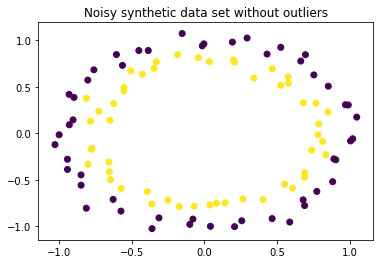

In [23]:
np.random.seed(9)
Xn,Yn = make_circles(n_samples=100, noise=0.06, factor=0.8)
pl.scatter(Xn[:, 0], Xn[:, 1], marker='o', c=Yn)
plt.title("Noisy synthetic data set without outliers")
plt.show()

To add and vary the percentage of outliers more easily, we have designed some functions. The general methodology can be described as follows:   
* Starting from the new data set with noise, we will add the percentage of outliers.
* Then we divide the data set into a training-test set. 
* Finally we will train and test each algorithm. 


All the steps are repeated when we change the percentage of outliers. It is important to note that the basic data set is generated only once. It is modified according to the percentage of outliers. 

In [24]:
from sklearn.linear_model import Perceptron


def measure(outlier_rate,model,Xn,Yn):
    Yno = np.copy(Yn)
    Yno, outliers = flip(outlier_rate,Yno)
    xno_train, xno_test, yno_train, yno_test = train_test_split(Xn, Yno, test_size = .2, random_state = 25)
    model.fit(xno_train,yno_train)
    ynpred = model.predict(xno_test)
    ynpred = ynpred > 0.5
    report = classification_report(yno_test,ynpred,output_dict=True)
    report0 = report['0']
    report1 = report['1']
    reporta = report['accuracy']
    return report0,report1,reporta
   

def measure_design(outlier_rate,Xn,Yn):
    models = [per,GNB,svc_opt,knn_opt, RFC_opt]
    precision0 = []
    precision1 = []
    recall0 = []
    recall1 = []
    fscore0 = []
    fscore1 = []
    support0 = []
    support1 = []
    accuracy = []
    for model in models:
        report0,report1,reporta = measure(outlier_rate,model,Xn,Yn)
        precision0.append(report0['precision'])
        recall0.append(report0['recall'])
        fscore0.append(report0['f1-score'])
        support0.append(report0['support'])
        precision1.append(report1['precision'])
        recall1.append(report1['recall'])
        fscore1.append(report1['f1-score'])
        support1.append(report1['support'])
        accuracy.append(reporta)
    clas_report = [precision0,precision1,recall0,recall1,fscore0,fscore1,support0,support1,accuracy]
    clas_report = np.array(clas_report)
    return clas_report

per = Perceptron()
models_label = ['Perceptron','GNB','SVC','knn', 'RFC']
error_label = ["precision 0","precision 1","recall 0","recall 1","f1-score 0","f1-score 1","support 0","support 1","accuracy"]

We chose the perceptron as the inefficiency benchmark. It randomly classifies the data because the data are not linearly separable. At best, it divides the data in two by a straight line so that for any given data, there is more or less a 50% chance of being correctly classified. The number 0 and 1 in front of the model evolution statistics represents class 1 or 0. GNB, SVC, knn, RFC are Gaussian naive bayes, support vector classifier, k nearest neighbor and RandomForestClassifier respectively.

In [25]:
outlier_rate = 0
header = models_label
table = measure_design(outlier_rate,Xn,Yn)
index = error_label
print()
print("Classification report for {}% outliers".format(outlier_rate*100))
pd.DataFrame(table, columns = header,index = index)


Classification report for 0% outliers


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,Perceptron,GNB,SVC,knn,RFC
precision 0,0.157895,0.200000,0.800000,0.571429,0.666667
precision 1,0.000000,0.000000,1.000000,1.000000,1.000000
recall 0,0.750000,1.000000,1.000000,1.000000,1.000000
recall 1,0.000000,0.000000,0.937500,0.812500,0.875000
f1-score 0,0.260870,0.333333,0.888889,0.727273,0.800000
f1-score 1,0.000000,0.000000,0.967742,0.896552,0.933333
support 0,4.000000,4.000000,4.000000,4.000000,4.000000
support 1,16.000000,16.000000,16.000000,16.000000,16.000000
accuracy,0.150000,0.200000,0.950000,0.850000,0.900000


0% outlier table is our negative control. We can see that most of our algorithms does a pretty good job except for GNB and the perceptron.

In [26]:
outlier_rate = 0.05
header = models_label
table = measure_design(outlier_rate,Xn,Yn)
index = error_label
print()
print("Classification report for {}% outliers".format(outlier_rate*100))
pd.DataFrame(table, columns = header,index = index)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Classification report for 5.0% outliers


,Perceptron,GNB,SVC,knn,RFC
precision 0,0.250000,0.294118,0.800000,0.571429,0.666667
precision 1,0.750000,1.000000,0.933333,0.923077,0.928571
recall 0,0.400000,1.000000,0.800000,0.800000,0.800000
recall 1,0.600000,0.200000,0.933333,0.800000,0.866667
f1-score 0,0.307692,0.454545,0.800000,0.666667,0.727273
f1-score 1,0.666667,0.333333,0.933333,0.857143,0.896552
support 0,5.000000,5.000000,5.000000,5.000000,5.000000
support 1,15.000000,15.000000,15.000000,15.000000,15.000000
accuracy,0.550000,0.400000,0.900000,0.800000,0.850000


As expected, most of the algorithms have decreased their accuracy. They don't seem to take an account of the 5% outliers. There are some exception GNB and the perceptron which have an increasing accuracy. The best model seems still to be the SVC and the worst is still GNB.

In [27]:
outlier_rate = 0.1
header = models_label
table = measure_design(outlier_rate,Xn,Yn)
index = error_label
print()
print("Classification report for {}% outliers".format(outlier_rate*100))
pd.DataFrame(table, columns = header,index = index)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Classification report for 10.0% outliers


,Perceptron,GNB,SVC,knn,RFC
precision 0,0.250000,0.222222,0.600000,0.333333,0.500000
precision 1,0.833333,0.818182,0.933333,0.857143,0.928571
recall 0,0.500000,0.500000,0.750000,0.500000,0.750000
recall 1,0.625000,0.562500,0.875000,0.750000,0.812500
f1-score 0,0.333333,0.307692,0.666667,0.400000,0.600000
f1-score 1,0.714286,0.666667,0.903226,0.800000,0.866667
support 0,4.000000,4.000000,4.000000,4.000000,4.000000
support 1,16.000000,16.000000,16.000000,16.000000,16.000000
accuracy,0.600000,0.550000,0.850000,0.700000,0.800000


For 10% outliers, there is a slight decrease of the accuracy for SVC, knn and RFC. GNB and the perceptron have their accuracy still increasing.

In [28]:
outlier_rate = 0.2
header = models_label
table = measure_design(outlier_rate,Xn,Yn)
index = error_label
print()
print("Classification report for {}% outliers".format(outlier_rate*100))
pd.DataFrame(table, columns = header,index = index)


Classification report for 20.0% outliers


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,Perceptron,GNB,SVC,knn,RFC
precision 0,0.200000,0.222222,0.600000,0.285714,0.500
precision 1,0.800000,0.818182,0.933333,0.846154,0.875
recall 0,0.500000,0.500000,0.750000,0.500000,0.500
recall 1,0.500000,0.562500,0.875000,0.687500,0.875
f1-score 0,0.285714,0.307692,0.666667,0.363636,0.500
f1-score 1,0.615385,0.666667,0.903226,0.758621,0.875
support 0,4.000000,4.000000,4.000000,4.000000,4.000
support 1,16.000000,16.000000,16.000000,16.000000,16.000
accuracy,0.500000,0.550000,0.850000,0.650000,0.800


GNB and SVC show almost the same result as previously for 10%. The accuracy of the knn is decreasing slightly and increasing slightly for RFC.

In [29]:
outlier_rate = 0.3
header = models_label
table = measure_design(outlier_rate,Xn,Yn)
index = error_label
print()
print("Classification report for {}% outliers".format(outlier_rate*100))
pd.DataFrame(table, columns = header,index = index)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Classification report for 30.0% outliers


,Perceptron,GNB,SVC,knn,RFC
precision 0,0.000000,0.333333,1.000000,0.333333,0.666667
precision 1,0.800000,0.823529,0.842105,0.857143,0.882353
recall 0,0.000000,0.250000,0.250000,0.500000,0.500000
recall 1,1.000000,0.875000,1.000000,0.750000,0.937500
f1-score 0,0.000000,0.285714,0.400000,0.400000,0.571429
f1-score 1,0.888889,0.848485,0.914286,0.800000,0.909091
support 0,4.000000,4.000000,4.000000,4.000000,4.000000
support 1,16.000000,16.000000,16.000000,16.000000,16.000000
accuracy,0.800000,0.750000,0.850000,0.700000,0.850000


For 30% outliers, we can notice that all the accuracy score are almost the same as 0% outliers except for the perceptron, GNB and knn. Thirty percent outliers are high error rate ( of mislabeled data) and the algorithms don't seem robust enough to do the job. The accuracy of the perceptron is an artefact because it predicts all points in the same category. Also, there is an imbalance in the test sample.

## Influence of the outliers on real data set

We decided to pick Housing in London data set from kaggle. Let's explore the data set.

<font color="gray"> Sources:</font>
<br><br> <font color="gray">Data set: https://www.kaggle.com/justinas/housing-in-london</font>

In [30]:
data = pd.read_csv('datasets_619175_1118179_housing_in_london_monthly_variables.csv')
data = data.dropna()

print("The data's dimension are", data.shape)
print('The features of the data are: ', list(data.columns))

The data's dimension are (7375, 7)
The features of the data are:  ['date', 'area', 'average_price', 'code', 'houses_sold', 'no_of_crimes', 'borough_flag']


In [66]:
import pprint

column_unique_value={}
for i in data.columns:
   column_unique_value[i] = len(data[i].unique())
pprint.pprint(column_unique_value)

{'area': 33,
 'average_price': 7312,
 'borough_flag': 1,
 'code': 33,
 'date': 227,
 'houses_sold': 729,
 'no_of_crimes': 2658}


We decided to build two categories from the average price. we'd like to discriminate against houses that are worth cheap houses. An expensive house will be a house whose price is higher than the average price of houses in the given set. We chose to retain houses sold and number of crime as the main variables.

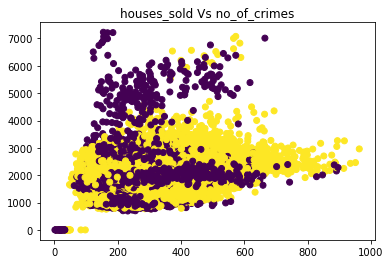

In [63]:
Yr = np.where( data['average_price'] < np.mean(data['average_price']), 1, 0)
Xr = data[['houses_sold', 'no_of_crimes']]
Xr = np.array(Xr)
pl.scatter(Xr[:, 0], Xr[:, 1], marker='o', c=Yr)
plt.title("houses_sold Vs no_of_crimes")
plt.show()

### Score of our models on real data set without outliers

We start by looking at the performance of the algorithms on the initial data set. The algorithms are taken with their default parameters.

In [67]:
outlier_rate = 0
header = models_label
table = measure_design(outlier_rate,Xr,Yr)
index = error_label
print()
print("Classification report for {}% outliers".format(outlier_rate*100))
pd.DataFrame(table, columns = header,index = index)


Classification report for 0% outliers


,Perceptron,GNB,SVC,knn,RFC
precision 0,0.473062,0.531250,0.866667,0.527629,0.656627
precision 1,0.725490,0.646142,0.638462,0.715536,0.658518
recall 0,0.647482,0.183453,0.070144,0.532374,0.196043
recall 1,0.563656,0.902067,0.993471,0.711643,0.937976
f1-score 0,0.546697,0.272727,0.129784,0.529991,0.301939
f1-score 1,0.634415,0.752952,0.777352,0.713584,0.773788
support 0,556.000000,556.000000,556.000000,556.000000,556.000000
support 1,919.000000,919.000000,919.000000,919.000000,919.000000
accuracy,0.595254,0.631186,0.645424,0.644068,0.658305


All the algorithms have very bad scores. It can be explained by the graph which shows that the two classes are very difficult to distinguish.

### Score of our models on real data set with outliers

In [69]:
outlier_rate = 0.10
header = models_label
table = measure_design(outlier_rate,Xr,Yr)
index = error_label
print()
print("Classification report for {}% outliers".format(outlier_rate*100))
pd.DataFrame(table, columns = header,index = index)


Classification report for 10.0% outliers


,Perceptron,GNB,SVC,knn,RFC
precision 0,0.639344,0.531746,0.625000,0.546326,0.584586
precision 1,0.601626,0.620784,0.630126,0.676090,0.675504
recall 0,0.126418,0.325770,0.283630,0.554295,0.504052
recall 1,0.948718,0.793706,0.877622,0.668998,0.742424
f1-score 0,0.211096,0.404020,0.390190,0.550282,0.541340
f1-score 1,0.736318,0.696675,0.733561,0.672525,0.707385
support 0,617.000000,617.000000,617.000000,617.000000,617.000000
support 1,858.000000,858.000000,858.000000,858.000000,858.000000
accuracy,0.604746,0.597966,0.629153,0.621017,0.642712


When we add 10% of mislabeling data to the data, we can notice slightly decrease accuracy for all algorithms except for the perceptron.

## Conclusion 

In this work, we investigated the effects of poor data annotation on the classification performance of different algorithms. This problem can be related to the problem of data containing outliers. It is important to specify before going any further that our results are indicative and not significant, since there is no repetition of measurements. This makes it impossible to know the measurement error. However, we can see trends.

The Gaussian naive bayes is the algorithm that presented the worst results on the synthetic data and the real data in our study. Moreover we cannot optimize it which reduces our margin of maneuver. We believe that the algorithm is not adapted to our data (in agreement with its cross validation score equal to 0.7 for data without noise or outliers). We cannot therefore estimate its resistance to outliers.

The Support Vector Classifier presented the best cross validation (first part) and accuracy scores.  This high precision score tends to show that it is highly sensitive to outliers as soon as the data has some noise. 

The Random Forest Classifier seems to have an intermediate sensitivity to outliers as well as the Vector Classifier Support and the K nearest neighbors Classifier. Its sensitivity may come from the fact that its rough approximation of a circle by a square depends strongly on the proportion of outliers in the training set.

K nearest neighbors Classifier seems to be the most resistant to outliers. Its accuracy is directly related to the rate of outliers in the data. 

To conclude, we find it difficult to know in advance if the data are poorly annotated or contain outliers. We think if a priori there is no way to clean the data that it is interesting to compare the results between two algorithms, one of which is highly resistant and the other very sensitive to the outlier. This could nuance the confidence in the results

## Bibliography

<font color="gray"> Sources:</font>
<font color="gray"> Abu-Mostafa, Yaser S., 1957-. (2012). Learning from data : a short course. [United States] :AMLBook.com, </font>
<br><br><font color="gray">Udacity SL6 - Kernel mathods & SVMs: https://www.udacity.com/</font>
<br><br> <font color="gray">Scikit-Learn: https://scikit-learn.org/stable/modules/naive_bayes.html</font>
<br><br> <font color="gray">Zhang, H. (2004). The optimality of naive Bayes. AA, 1(2), 3.</font>
<br><br> <font color="gray">Augmented Startups youtube video: https://youtu.be/CPqOCI0ahss</font>
<br><br> <font color="gray">Scikit-Learn: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html</font>
<font color="gray"> Sources:</font>
<br><br><font color="gray"> Abu-Mostafa, Yaser S., 1957-. (2012). Learning from data : a short course. [United States] :AMLBook.com, </font>
<br><br><font color="gray"> Space reductionn demonstration by Dougal: https://stats.stackexchange.com/users/9964/dougal  </font>
<br><br><font color="gray">StatQuest with Josh Starmer: https://youtu.be/efR1C6CvhmE  , based on Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani. (2013). An introduction to statistical learning : with applications in R. New York :Springer, chap 9.1 to 9.4 </font>
<br><br> <font color="gray">Scikit-Learn: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html</font>
<br><br><font color="gray"> University of Utah - Machine learning course  </font>
<br><br><font color="gray"> StatQuest with josh Stamer: https://youtu.be/HVXime0nQeI  </font>
<br><br><font color="gray"> Udacty, SL4 - Intance based learning https://www.udacity.com/ </font>
<br><br> <font color="gray">Scikit-Learn: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html</font>
<br><br><font color="gray"> Biau, G., & Scornet, E. (2016). A random forest guided tour. TEST, 25(2), 197–227. https://doi.org/10.1007/s11749-016-0481-7  </font>
<br><br><font color="gray"> StatQuest with josh Stamer: https://youtu.be/J4Wdy0Wc_xQ </font>
<br><br> <font color="gray">Scikit-Learn: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html</font>
<br><br> <font color="gray">Data set: https://www.kaggle.com/justinas/housing-in-london</font>